# Step 2b: Train RNN Model with Pre-computed Embeddings

This notebook loads pre-computed embeddings from Google Drive and trains the RNN model.

**Advantages:**
- No need to reload LLM or recompute embeddings
- Much faster training iterations
- Can experiment with different hyperparameters easily
- Uses proper RNN sequence processing (no sliding windows)

## 1. Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

print("✓ Google Drive mounted successfully!")

Mounted at /content/drive
✓ Google Drive mounted successfully!


## 2. Setup and Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import os
from tqdm import tqdm
import json
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

## 3. Configuration

In [3]:
# ==================== IMPORTANT: SET THIS PATH ====================
# Path to your embeddings directory (from 2a_create_all_embeddings_colab.ipynb)
# Example: "/content/drive/MyDrive/RNN_All_Embeddings/20231203_153045"
EMBEDDINGS_DIR = "/content/drive/MyDrive/RNN_All_Embeddings/20251204_045020"

# ==================================================================

# Output directory for training results
TRAINING_OUTPUT_DIR = os.path.join(
    "/content/drive/MyDrive/RNN_Training_Results",
    datetime.now().strftime("%Y%m%d_%H%M%S")
)
os.makedirs(TRAINING_OUTPUT_DIR, exist_ok=True)

print(f"Embeddings directory: {EMBEDDINGS_DIR}")
print(f"Training results will be saved to: {TRAINING_OUTPUT_DIR}")

# Batch Size
TRAIN_BATCH_SIZE = 16

# Model Configuration
HIDDEN_DIM = 128
NUM_LAYERS = 2
DROPOUT = 0.4

# Training Configuration
EPOCHS = 50
LEARNING_RATE = 0.001
PATIENCE = 10

print(f"\nConfiguration:")
print(f"  Model: Hidden={HIDDEN_DIM}, Layers={NUM_LAYERS}, Dropout={DROPOUT}")
print(f"  Training: Epochs={EPOCHS}, LR={LEARNING_RATE}, Batch={TRAIN_BATCH_SIZE}")

Embeddings directory: /content/drive/MyDrive/RNN_All_Embeddings/20251204_045020
Training results will be saved to: /content/drive/MyDrive/RNN_Training_Results/20251204_051426

Configuration:
  Model: Hidden=128, Layers=2, Dropout=0.4
  Training: Epochs=50, LR=0.001, Batch=16


## 4. Load Pre-computed Embeddings

In [ ]:
# Load embeddings
embeddings_file = os.path.join(EMBEDDINGS_DIR, "embeddings.pkl")
metadata_file = os.path.join(EMBEDDINGS_DIR, "embeddings_metadata.json")

print(f"Loading embeddings from: {embeddings_file}")

if not os.path.exists(embeddings_file):
    raise FileNotFoundError(
        f"Embeddings not found at: {embeddings_file}\n"
        f"Please run '2a_create_all_embeddings_colab.ipynb' first and update EMBEDDINGS_DIR."
    )

with open(embeddings_file, 'rb') as f:
    embeddings_data = pickle.load(f)

# Use only original embeddings (not concatenated with injected)
train_sequences = embeddings_data['train']['original_sequences']
train_labels = embeddings_data['train']['labels']

val_sequences = embeddings_data['val']['original_sequences']
val_labels = embeddings_data['val']['labels']

test_sequences = embeddings_data['test']['original_sequences']
test_labels = embeddings_data['test']['labels']

print(f"✓ Loaded embeddings:")
print(f"  Train: {len(train_sequences)} documents")
print(f"  Val:   {len(val_sequences)} documents")
print(f"  Test:  {len(test_sequences)} documents")
print(f"\n✓ Using only original sentence embeddings (no concatenation)")
print(f"  Embedding dim: {train_sequences[0].shape[1]}")

# Load metadata
if os.path.exists(metadata_file):
    with open(metadata_file, 'r') as f:
        metadata = json.load(f)
    print(f"\n✓ Metadata loaded")
    print(f"  Creation date: {metadata['creation_timestamp']}")
    print(f"  Model: {metadata['model_id']}")
    print(f"  Original embedding dim: {metadata.get('original_embedding_dim', 'N/A')}")
    print(f"  Injected embedding dim: {metadata.get('injected_embedding_dim', 'N/A')}")

## 5. Device Setup

In [5]:
# Device Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\n✓ Using device: {device}")
if device == "cuda":
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


✓ Using device: cpu


## 6. RNN Model Architecture

In [6]:
class SequenceArtifactDetector(nn.Module):
    """
    Bidirectional LSTM for detecting AI-generated text based on sequential patterns.
    Processes variable-length document sequences.
    """

    def __init__(self, embedding_dim, hidden_dim=256, num_layers=2, dropout=0.3):
        super(SequenceArtifactDetector, self).__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )

        lstm_output_dim = hidden_dim * 2  # *2 for bidirectional

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(lstm_output_dim, lstm_output_dim // 2),
            nn.Tanh(),
            nn.Linear(lstm_output_dim // 2, 1),
            nn.Softmax(dim=1)
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                if 'lstm' in name:
                    nn.init.xavier_uniform_(param)
                elif len(param.shape) >= 2:
                    nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def forward(self, x, lengths):
        """
        Args:
            x: (batch_size, max_seq_len, embedding_dim)
            lengths: (batch_size,) actual lengths of sequences
        """
        # Pack padded sequence
        packed = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )

        # LSTM forward
        packed_out, (hidden, cell) = self.lstm(packed)

        # Unpack
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)

        # Attention mechanism
        attention_weights = self.attention(lstm_out)
        attended = torch.sum(lstm_out * attention_weights, dim=1)

        # Classification
        output = self.classifier(attended)
        return output

print("✓ Model architecture defined")

✓ Model architecture defined


## 7. Dataset Class and Collate Function

In [7]:
class SequenceDataset(Dataset):
    """Dataset that returns variable-length sequences."""

    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


def collate_fn(batch):
    """
    Collate function to pad variable-length sequences in a batch.

    Args:
        batch: List of (sequence, label) tuples

    Returns:
        padded_sequences: (batch_size, max_len, embedding_dim)
        labels: (batch_size, 1)
        lengths: (batch_size,) actual sequence lengths
    """
    sequences, labels = zip(*batch)

    # Get lengths
    lengths = torch.tensor([len(seq) for seq in sequences])

    # Pad sequences
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0.0)

    # Stack labels
    labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

    return padded_sequences, labels, lengths

print("✓ Dataset class and collate function defined")

✓ Dataset class and collate function defined


## 8. Create DataLoaders

In [8]:
train_dataset = SequenceDataset(train_sequences, train_labels)
val_dataset = SequenceDataset(val_sequences, val_labels)
test_dataset = SequenceDataset(test_sequences, test_labels)

train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

print(f"\n✓ DataLoaders created:")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"\n  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")
print(f"  Test samples: {len(test_dataset)}")


✓ DataLoaders created:
  Training batches: 223
  Validation batches: 75
  Test batches: 75

  Training samples: 3554
  Validation samples: 1185
  Test samples: 1185


## 9. Training Function

In [9]:
def train_model(train_loader, val_loader, embedding_dim, epochs=50, lr=0.001,
                hidden_dim=256, num_layers=2, dropout=0.3):
    print("\n" + "="*70)
    print("Training RNN Sequence Detector")
    print("="*70)

    model = SequenceArtifactDetector(
        embedding_dim=embedding_dim,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout=dropout
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

    best_val_acc = 0.0
    patience_counter = 0

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        "learning_rate": []
    }

    print(f"\nModel Configuration:")
    print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"  Training samples: {len(train_loader.dataset)}")
    print(f"  Validation samples: {len(val_loader.dataset)}")
    print("="*70 + "\n")

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for batch_X, batch_y, lengths in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            lengths = lengths.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X, lengths)
            loss = criterion(outputs, batch_y)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item()
            predictions = (outputs > 0.5).float()
            train_correct += (predictions == batch_y).sum().item()
            train_total += batch_y.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_X, batch_y, lengths in val_loader:
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)
                lengths = lengths.to(device)

                outputs = model(batch_X, lengths)
                loss = criterion(outputs, batch_y)

                val_loss += loss.item()
                predictions = (outputs > 0.5).float()
                val_correct += (predictions == batch_y).sum().item()
                val_total += batch_y.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total

        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        history["train_loss"].append(avg_train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(avg_val_loss)
        history["val_acc"].append(val_acc)
        history["learning_rate"].append(current_lr)

        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
              f"LR: {current_lr:.6f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_acc': val_acc,
                'val_loss': avg_val_loss,
                'embedding_dim': embedding_dim,
                'hidden_dim': hidden_dim,
                'num_layers': num_layers,
                'dropout': dropout
            }
            torch.save(checkpoint, os.path.join(TRAINING_OUTPUT_DIR, "best_model.pth"))
            print(f"  ✓ New best model saved! (Val Acc: {val_acc:.2f}%)")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

    print(f"\n{'='*70}")
    print(f"Training complete!")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")
    print(f"{'='*70}\n")

    # Load best model
    checkpoint = torch.load(os.path.join(TRAINING_OUTPUT_DIR, "best_model.pth"), weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    return model, history

print("✓ Training function defined")

✓ Training function defined


## 10. Train the Model

In [10]:
# Get embedding dimension from concatenated sequences
embedding_dim = train_sequences[0].shape[1]  # This is original_dim + injected_dim

print(f"Using embedding dimension: {embedding_dim}")

model, history = train_model(
    train_loader, val_loader, embedding_dim,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
)

Using embedding dimension: 4096

Training RNN Sequence Detector

Model Configuration:
  Parameters: 4,796,930
  Training samples: 3554
  Validation samples: 1185



Epoch 1/50: 100%|██████████| 223/223 [04:12<00:00,  1.13s/it]


Epoch [1/50] | Train Loss: 0.6887 | Train Acc: 52.14% | Val Loss: 0.6839 | Val Acc: 54.09% | LR: 0.000999
  ✓ New best model saved! (Val Acc: 54.09%)


Epoch 2/50: 100%|██████████| 223/223 [05:11<00:00,  1.40s/it]


Epoch [2/50] | Train Loss: 0.6892 | Train Acc: 51.24% | Val Loss: 0.6824 | Val Acc: 52.41% | LR: 0.000996


Epoch 3/50: 100%|██████████| 223/223 [04:47<00:00,  1.29s/it]


Epoch [3/50] | Train Loss: 0.6855 | Train Acc: 52.93% | Val Loss: 0.6844 | Val Acc: 53.92% | LR: 0.000991


Epoch 4/50: 100%|██████████| 223/223 [04:27<00:00,  1.20s/it]


Epoch [4/50] | Train Loss: 0.6881 | Train Acc: 53.26% | Val Loss: 0.6815 | Val Acc: 54.35% | LR: 0.000984
  ✓ New best model saved! (Val Acc: 54.35%)


Epoch 5/50: 100%|██████████| 223/223 [04:44<00:00,  1.27s/it]


Epoch [5/50] | Train Loss: 0.6879 | Train Acc: 53.43% | Val Loss: 0.6838 | Val Acc: 52.32% | LR: 0.000976


Epoch 6/50: 100%|██████████| 223/223 [04:48<00:00,  1.29s/it]


Epoch [6/50] | Train Loss: 0.6879 | Train Acc: 53.40% | Val Loss: 0.6824 | Val Acc: 54.68% | LR: 0.000965
  ✓ New best model saved! (Val Acc: 54.68%)


Epoch 7/50: 100%|██████████| 223/223 [04:37<00:00,  1.25s/it]


Epoch [7/50] | Train Loss: 0.6888 | Train Acc: 53.12% | Val Loss: 0.6814 | Val Acc: 53.84% | LR: 0.000952


Epoch 8/50: 100%|██████████| 223/223 [04:13<00:00,  1.14s/it]


Epoch [8/50] | Train Loss: 0.6771 | Train Acc: 56.05% | Val Loss: 0.6877 | Val Acc: 53.00% | LR: 0.000938


Epoch 9/50: 100%|██████████| 223/223 [04:34<00:00,  1.23s/it]


Epoch [9/50] | Train Loss: 0.3474 | Train Acc: 87.20% | Val Loss: 0.2089 | Val Acc: 93.84% | LR: 0.000922
  ✓ New best model saved! (Val Acc: 93.84%)


Epoch 10/50: 100%|██████████| 223/223 [04:42<00:00,  1.27s/it]


Epoch [10/50] | Train Loss: 0.1807 | Train Acc: 94.32% | Val Loss: 0.0879 | Val Acc: 97.38% | LR: 0.000905
  ✓ New best model saved! (Val Acc: 97.38%)


Epoch 11/50: 100%|██████████| 223/223 [04:34<00:00,  1.23s/it]


Epoch [11/50] | Train Loss: 0.2019 | Train Acc: 93.58% | Val Loss: 0.2294 | Val Acc: 95.19% | LR: 0.000885


Epoch 12/50: 100%|██████████| 223/223 [04:51<00:00,  1.31s/it]


Epoch [12/50] | Train Loss: 0.1393 | Train Acc: 95.81% | Val Loss: 0.0910 | Val Acc: 97.38% | LR: 0.000865


Epoch 13/50: 100%|██████████| 223/223 [05:03<00:00,  1.36s/it]


Epoch [13/50] | Train Loss: 0.1276 | Train Acc: 96.40% | Val Loss: 0.0787 | Val Acc: 97.97% | LR: 0.000842
  ✓ New best model saved! (Val Acc: 97.97%)


Epoch 14/50: 100%|██████████| 223/223 [05:09<00:00,  1.39s/it]


Epoch [14/50] | Train Loss: 0.0972 | Train Acc: 97.13% | Val Loss: 0.0706 | Val Acc: 97.89% | LR: 0.000819


Epoch 15/50: 100%|██████████| 223/223 [05:01<00:00,  1.35s/it]


Epoch [15/50] | Train Loss: 0.1130 | Train Acc: 96.43% | Val Loss: 0.2551 | Val Acc: 92.49% | LR: 0.000794


Epoch 16/50: 100%|██████████| 223/223 [05:09<00:00,  1.39s/it]


Epoch [16/50] | Train Loss: 0.1145 | Train Acc: 96.96% | Val Loss: 0.0634 | Val Acc: 97.97% | LR: 0.000768


Epoch 17/50: 100%|██████████| 223/223 [05:18<00:00,  1.43s/it]


Epoch [17/50] | Train Loss: 0.0781 | Train Acc: 97.81% | Val Loss: 0.1001 | Val Acc: 97.30% | LR: 0.000741


Epoch 18/50: 100%|██████████| 223/223 [05:16<00:00,  1.42s/it]


Epoch [18/50] | Train Loss: 0.1034 | Train Acc: 97.24% | Val Loss: 0.0774 | Val Acc: 97.89% | LR: 0.000713


Epoch 19/50: 100%|██████████| 223/223 [05:14<00:00,  1.41s/it]


Epoch [19/50] | Train Loss: 0.0911 | Train Acc: 97.33% | Val Loss: 0.0662 | Val Acc: 98.06% | LR: 0.000684
  ✓ New best model saved! (Val Acc: 98.06%)


Epoch 20/50: 100%|██████████| 223/223 [05:06<00:00,  1.37s/it]


Epoch [20/50] | Train Loss: 0.1073 | Train Acc: 96.85% | Val Loss: 0.0585 | Val Acc: 98.40% | LR: 0.000655
  ✓ New best model saved! (Val Acc: 98.40%)


Epoch 21/50: 100%|██████████| 223/223 [05:18<00:00,  1.43s/it]


Epoch [21/50] | Train Loss: 0.0980 | Train Acc: 97.72% | Val Loss: 0.0842 | Val Acc: 97.30% | LR: 0.000625


Epoch 22/50: 100%|██████████| 223/223 [05:12<00:00,  1.40s/it]


Epoch [22/50] | Train Loss: 0.0738 | Train Acc: 97.81% | Val Loss: 0.1335 | Val Acc: 96.46% | LR: 0.000594


Epoch 23/50: 100%|██████████| 223/223 [05:27<00:00,  1.47s/it]


Epoch [23/50] | Train Loss: 0.0653 | Train Acc: 98.06% | Val Loss: 0.0599 | Val Acc: 98.31% | LR: 0.000563


Epoch 24/50: 100%|██████████| 223/223 [05:29<00:00,  1.48s/it]


Epoch [24/50] | Train Loss: 0.0735 | Train Acc: 98.03% | Val Loss: 0.0625 | Val Acc: 98.48% | LR: 0.000532
  ✓ New best model saved! (Val Acc: 98.48%)


Epoch 25/50: 100%|██████████| 223/223 [05:33<00:00,  1.50s/it]


Epoch [25/50] | Train Loss: 0.0649 | Train Acc: 98.26% | Val Loss: 0.0630 | Val Acc: 98.23% | LR: 0.000500


Epoch 26/50: 100%|██████████| 223/223 [05:35<00:00,  1.50s/it]


Epoch [26/50] | Train Loss: 0.0615 | Train Acc: 98.20% | Val Loss: 0.0599 | Val Acc: 98.14% | LR: 0.000469


Epoch 27/50: 100%|██████████| 223/223 [05:55<00:00,  1.60s/it]


Epoch [27/50] | Train Loss: 0.0438 | Train Acc: 98.68% | Val Loss: 0.0619 | Val Acc: 98.23% | LR: 0.000438


Epoch 28/50: 100%|██████████| 223/223 [05:45<00:00,  1.55s/it]


Epoch [28/50] | Train Loss: 0.0479 | Train Acc: 98.56% | Val Loss: 0.0807 | Val Acc: 97.47% | LR: 0.000407


Epoch 29/50: 100%|██████████| 223/223 [05:47<00:00,  1.56s/it]


Epoch [29/50] | Train Loss: 0.0554 | Train Acc: 98.56% | Val Loss: 0.0900 | Val Acc: 97.55% | LR: 0.000376


Epoch 30/50: 100%|██████████| 223/223 [05:53<00:00,  1.59s/it]


Epoch [30/50] | Train Loss: 0.0595 | Train Acc: 98.28% | Val Loss: 0.0615 | Val Acc: 98.31% | LR: 0.000346


Epoch 31/50: 100%|██████████| 223/223 [05:43<00:00,  1.54s/it]


Epoch [31/50] | Train Loss: 0.0463 | Train Acc: 98.76% | Val Loss: 0.0539 | Val Acc: 97.97% | LR: 0.000317


Epoch 32/50: 100%|██████████| 223/223 [05:50<00:00,  1.57s/it]


Epoch [32/50] | Train Loss: 0.0515 | Train Acc: 98.76% | Val Loss: 0.0549 | Val Acc: 98.14% | LR: 0.000288


Epoch 33/50: 100%|██████████| 223/223 [05:44<00:00,  1.55s/it]


Epoch [33/50] | Train Loss: 0.0480 | Train Acc: 98.82% | Val Loss: 0.0550 | Val Acc: 98.65% | LR: 0.000260
  ✓ New best model saved! (Val Acc: 98.65%)


Epoch 34/50: 100%|██████████| 223/223 [05:54<00:00,  1.59s/it]


Epoch [34/50] | Train Loss: 0.0460 | Train Acc: 98.96% | Val Loss: 0.1179 | Val Acc: 97.13% | LR: 0.000233


Epoch 35/50: 100%|██████████| 223/223 [05:52<00:00,  1.58s/it]


Epoch [35/50] | Train Loss: 0.0363 | Train Acc: 99.07% | Val Loss: 0.0498 | Val Acc: 98.82% | LR: 0.000207
  ✓ New best model saved! (Val Acc: 98.82%)


Epoch 36/50: 100%|██████████| 223/223 [05:53<00:00,  1.58s/it]


Epoch [36/50] | Train Loss: 0.0428 | Train Acc: 98.85% | Val Loss: 0.0719 | Val Acc: 98.23% | LR: 0.000182


Epoch 37/50: 100%|██████████| 223/223 [05:55<00:00,  1.59s/it]


Epoch [37/50] | Train Loss: 0.0400 | Train Acc: 98.82% | Val Loss: 0.0801 | Val Acc: 97.81% | LR: 0.000159


Epoch 38/50: 100%|██████████| 223/223 [05:54<00:00,  1.59s/it]


Epoch [38/50] | Train Loss: 0.0327 | Train Acc: 99.18% | Val Loss: 0.0684 | Val Acc: 98.31% | LR: 0.000136


Epoch 39/50: 100%|██████████| 223/223 [05:55<00:00,  1.59s/it]


Epoch [39/50] | Train Loss: 0.0429 | Train Acc: 98.79% | Val Loss: 0.0605 | Val Acc: 98.48% | LR: 0.000116


Epoch 40/50: 100%|██████████| 223/223 [05:50<00:00,  1.57s/it]


Epoch [40/50] | Train Loss: 0.0327 | Train Acc: 99.04% | Val Loss: 0.0841 | Val Acc: 97.55% | LR: 0.000096


Epoch 41/50: 100%|██████████| 223/223 [05:45<00:00,  1.55s/it]


Epoch [41/50] | Train Loss: 0.0282 | Train Acc: 99.27% | Val Loss: 0.0778 | Val Acc: 97.97% | LR: 0.000079


Epoch 42/50: 100%|██████████| 223/223 [05:52<00:00,  1.58s/it]


Epoch [42/50] | Train Loss: 0.0326 | Train Acc: 99.21% | Val Loss: 0.0893 | Val Acc: 97.72% | LR: 0.000063


Epoch 43/50: 100%|██████████| 223/223 [05:47<00:00,  1.56s/it]


Epoch [43/50] | Train Loss: 0.0317 | Train Acc: 99.27% | Val Loss: 0.0599 | Val Acc: 98.48% | LR: 0.000049


Epoch 44/50: 100%|██████████| 223/223 [05:48<00:00,  1.56s/it]


Epoch [44/50] | Train Loss: 0.0307 | Train Acc: 99.13% | Val Loss: 0.0802 | Val Acc: 97.89% | LR: 0.000036


Epoch 45/50: 100%|██████████| 223/223 [05:44<00:00,  1.55s/it]


Epoch [45/50] | Train Loss: 0.0274 | Train Acc: 99.32% | Val Loss: 0.0756 | Val Acc: 98.23% | LR: 0.000025

Early stopping at epoch 45

Training complete!
Best validation accuracy: 98.82%



## 11. Save Training Results

In [11]:
# Save training history
with open(os.path.join(TRAINING_OUTPUT_DIR, "training_history.json"), "w") as f:
    json.dump(history, f, indent=2)

print(f"✓ Training history saved to Google Drive")

✓ Training history saved to Google Drive


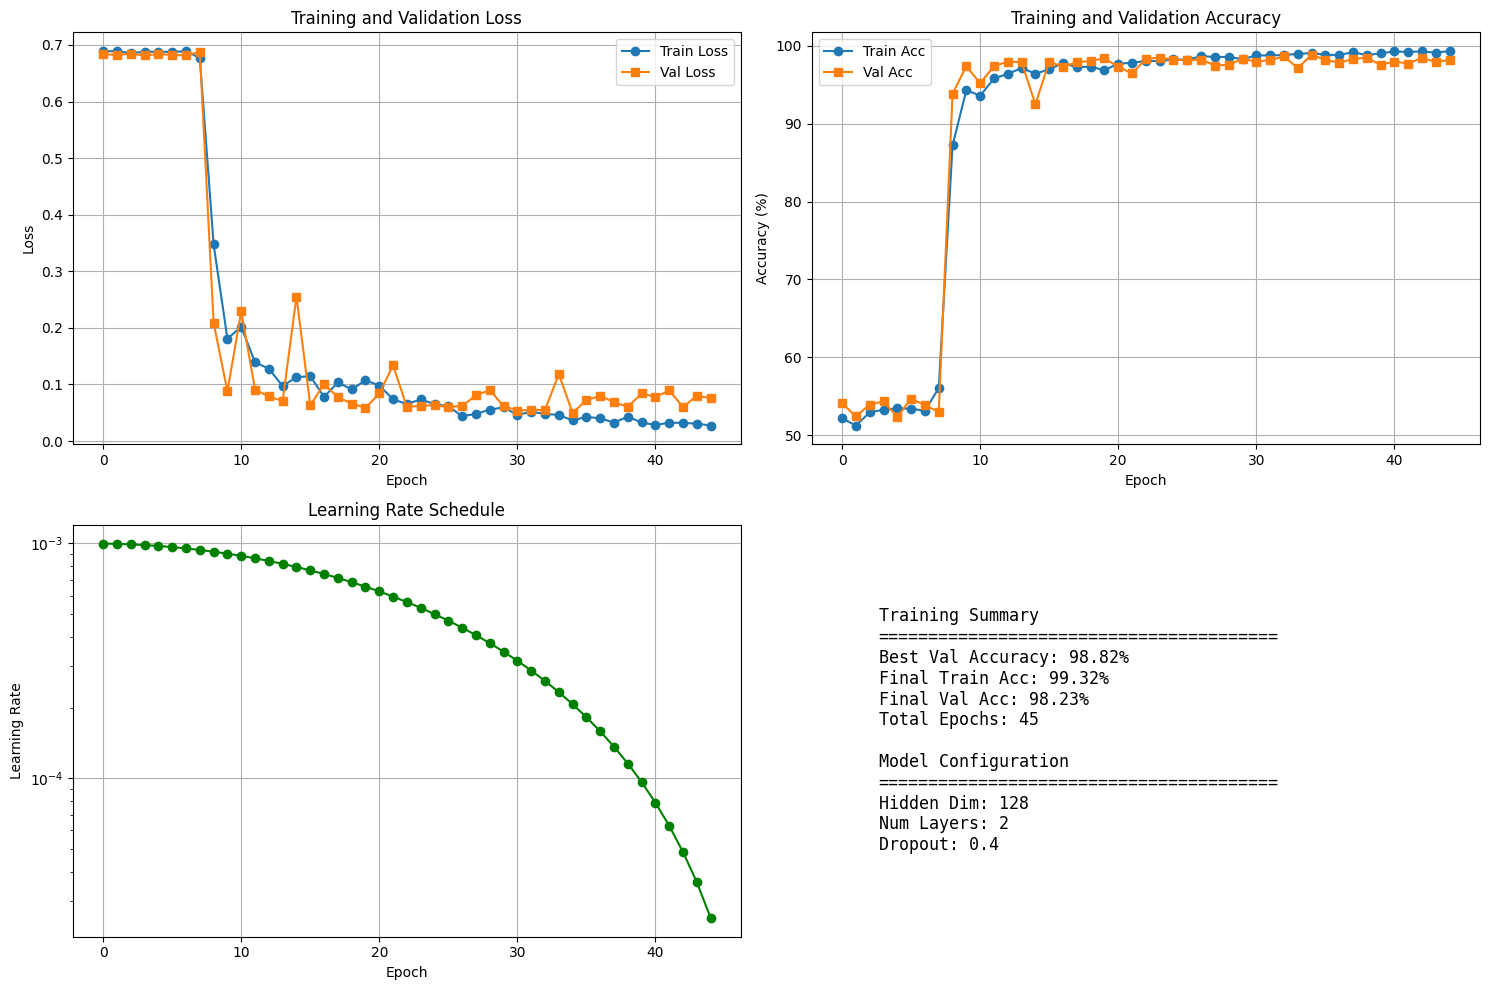

✓ Training curves saved to Google Drive


In [12]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[0, 1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].plot(history['learning_rate'], marker='o', color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True)

axes[1, 1].axis('off')
summary_text = f"""
Training Summary
{'='*40}
Best Val Accuracy: {max(history['val_acc']):.2f}%
Final Train Acc: {history['train_acc'][-1]:.2f}%
Final Val Acc: {history['val_acc'][-1]:.2f}%
Total Epochs: {len(history['train_loss'])}

Model Configuration
{'='*40}
Hidden Dim: {HIDDEN_DIM}
Num Layers: {NUM_LAYERS}
Dropout: {DROPOUT}
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=12, family='monospace',
                verticalalignment='center')

plt.tight_layout()
plt.savefig(os.path.join(TRAINING_OUTPUT_DIR, "training_curves.png"), dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Training curves saved to Google Drive")

## 12. Evaluate on Test Set

In [13]:
print("\n" + "="*70)
print("Evaluating on Test Set")
print("="*70)

model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch_X, batch_y, lengths in tqdm(test_loader, desc="Testing"):
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        lengths = lengths.to(device)

        outputs = model(batch_X, lengths)
        predictions = (outputs > 0.5).float()

        all_preds.extend(predictions.cpu().numpy())
        all_true.extend(batch_y.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_true, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_true, all_preds, average='binary', zero_division=0
)
cm = confusion_matrix(all_true, all_preds)

# Print results
print("\n" + "="*70)
print("FINAL TEST RESULTS")
print("="*70)
print(f"Accuracy:  {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall:    {recall*100:.2f}%")
print(f"F1 Score:  {f1*100:.2f}%")
print(f"\nConfusion Matrix:")
print(f"                Predicted")
print(f"              Human    AI")
print(f"Actual Human    {cm[0][0]:3d}    {cm[0][1]:3d}")
print(f"       AI       {cm[1][0]:3d}    {cm[1][1]:3d}")
print("="*70)


Evaluating on Test Set


Testing: 100%|██████████| 75/75 [00:11<00:00,  6.49it/s]


FINAL TEST RESULTS
Accuracy:  97.22%
Precision: 98.28%
Recall:    96.14%
F1 Score:  97.20%

Confusion Matrix:
                Predicted
              Human    AI
Actual Human    579     10
       AI        23    573


## 13. Save Test Results to Google Drive

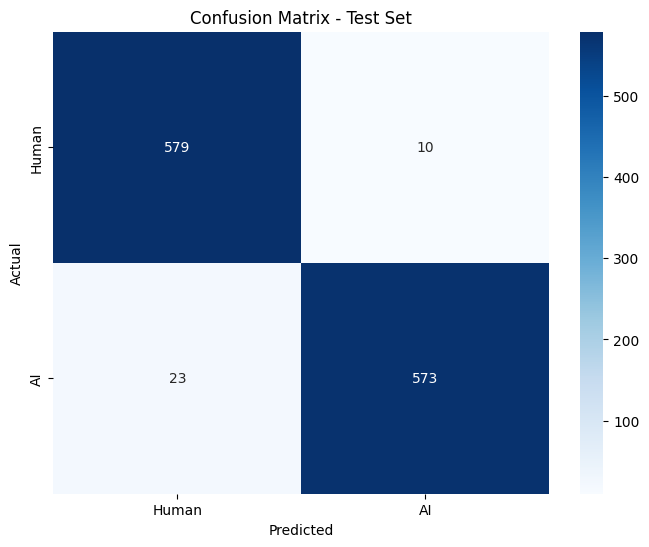


✓ Test results saved to Google Drive


In [14]:
# Save test metrics
test_results = {
    "accuracy": float(accuracy),
    "precision": float(precision),
    "recall": float(recall),
    "f1_score": float(f1),
    "confusion_matrix": cm.tolist(),
    "num_test_samples": len(test_dataset),
    "timestamp": datetime.now().isoformat()
}

with open(os.path.join(TRAINING_OUTPUT_DIR, "test_results.json"), "w") as f:
    json.dump(test_results, f, indent=2)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Human', 'AI'],
            yticklabels=['Human', 'AI'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.savefig(os.path.join(TRAINING_OUTPUT_DIR, "confusion_matrix.png"), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Test results saved to Google Drive")

## 14. Save Complete Configuration

In [15]:
config = {
    "embeddings_path": EMBEDDINGS_DIR,
    "training_output_path": TRAINING_OUTPUT_DIR,
    "dataset": {
        "train_samples": len(train_dataset),
        "val_samples": len(val_dataset),
        "test_samples": len(test_dataset)
    },
    "model": {
        "architecture": "Bidirectional LSTM with Attention",
        "embedding_dim": embedding_dim,
        "hidden_dim": HIDDEN_DIM,
        "num_layers": NUM_LAYERS,
        "dropout": DROPOUT,
        "total_parameters": sum(p.numel() for p in model.parameters()),
        "uses_sliding_windows": False
    },
    "training": {
        "epochs": EPOCHS,
        "learning_rate": LEARNING_RATE,
        "batch_size": TRAIN_BATCH_SIZE,
        "patience": PATIENCE,
        "actual_epochs_trained": len(history['train_loss'])
    },
    "results": {
        "best_val_accuracy": max(history['val_acc']),
        "test_accuracy": float(accuracy),
        "test_precision": float(precision),
        "test_recall": float(recall),
        "test_f1": float(f1)
    },
    "device": device,
    "timestamp": datetime.now().isoformat()
}

with open(os.path.join(TRAINING_OUTPUT_DIR, "full_config.json"), "w") as f:
    json.dump(config, f, indent=2)

print(f"✓ Full configuration saved to Google Drive")

✓ Full configuration saved to Google Drive


## 15. Summary

In [16]:
print("\n" + "="*70)
print("TRAINING COMPLETE - SUMMARY")
print("="*70)
print(f"\n✓ All results saved to Google Drive:")
print(f"  {TRAINING_OUTPUT_DIR}\n")
print(f"Saved files:")
print(f"  1. best_model.pth - Best trained model")
print(f"  2. training_history.json - Training history")
print(f"  3. training_curves.png - Training visualization")
print(f"  4. test_results.json - Test metrics")
print(f"  5. confusion_matrix.png - Confusion matrix")
print(f"  6. full_config.json - Complete configuration\n")
print(f"Final Results:")
print(f"  Best Val Accuracy: {max(history['val_acc']):.2f}%")
print(f"  Test Accuracy: {accuracy*100:.2f}%")
print(f"  Test F1 Score: {f1*100:.2f}%\n")
print(f"Model Architecture:")
print(f"  Proper RNN sequence processing (no sliding windows)")
print(f"  Each document processed as a single variable-length sequence\n")
print(f"Training completed using embeddings from:")
print(f"  {EMBEDDINGS_DIR}")
print("="*70)


TRAINING COMPLETE - SUMMARY

✓ All results saved to Google Drive:
  /content/drive/MyDrive/RNN_Training_Results/20251204_051426

Saved files:
  1. best_model.pth - Best trained model
  2. training_history.json - Training history
  3. training_curves.png - Training visualization
  4. test_results.json - Test metrics
  5. confusion_matrix.png - Confusion matrix
  6. full_config.json - Complete configuration

Final Results:
  Best Val Accuracy: 98.82%
  Test Accuracy: 97.22%
  Test F1 Score: 97.20%

Model Architecture:
  Proper RNN sequence processing (no sliding windows)
  Each document processed as a single variable-length sequence

Training completed using embeddings from:
  /content/drive/MyDrive/RNN_All_Embeddings/20251204_045020
